<a href="https://colab.research.google.com/github/Wimmics/kgstat/blob/main/KG_and_Classification_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying statistical classification methods to meteorological data knowledge graph WeKG-MF 
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)

This notebook demonstrates how to access and query WeKG-MF RDF dataset and apply classification methods to the query results. In this notebook, we are going to explore how can use weather data and statistical models to classify wine growing regions and grape varieties.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions. 

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo. 

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Winkler, Albert Julius. General viticulture. Univ of California Press, 1974. Book.

Jones, Gregory V., Andrew A. Duff, Andrew Hall, and Joseph W. Myers. "Spatial analysis of climate in winegrape growing regions in the western United States." American Journal of Enology and Viticulture 61, no. 3 (2010): 313-326. https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf

Van Leeuwen, CornelIs, C. Garnier, C. Agut, Bernard Baculat, Gerard Barbeau, E. Besnard, B. Bois et al. "Heat requirements for grapevine varieties is essential information to adapt plant material in a changing climate." In 7. Congrès International des Terroirs Viticoles. 2008. https://hal.inrae.fr/hal-02758537/file/28929_20110210031815860_1.pdf





In [1]:
R.Version()$version

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

## Setup


NOTE: If you are running this notebook in Google Colab it may take a long time to install some packages. At the moment we didn't find a remedy for this. Please be patient, have a cup of tea	🍵.

### Enable querying of the Knowledge Graph  
The easiest way to access and query the dataset endpoint is to use the R package `SPARQL`. However, it was recently removed from the CRAN repository but still can be installed from the [archive](https://cran.r-project.org/src/contrib/Archive/SPARQL/).

To access and query Knowledge Graph [RDF](https://www.w3.org/RDF/) representaion from files we will use `rdflib` package, a friendly and consise user interface for performing common tasks on rdf data, such as parsing serializing and  performing SPARQL queries. 

In [181]:
options(warn=-1) # to turn warnings back on use options(warn=0)

if (!require(SPARQL)) {
  install.packages("XML", quiet=TRUE)
  install.packages("RCurl", quiet=TRUE)
  install.packages("https://cran.r-project.org/src/contrib/Archive/SPARQL/SPARQL_1.16.tar.gz",
                    repos=NULL, type="source",  quiet=TRUE)
}
library(SPARQL)  

if (!require(rdflib) ) {
  if (Sys.info()[["sysname"]] == "Linux") {
      system('sudo apt install librdf0 librdf0-dev')
      install.packages("redland")
  }
  install.packages("rdflib")
}
library(rdflib)

### Define dataset endpoint for the SPARQL data access

NOTE: depending on the runtime environment an *https* endpoint URL may lead to an error. In this case, try to change it to *http*.

In [3]:
endpoint <- "http://weakg.i3s.unice.fr/sparql"
options <- NULL

### Define prefixes to abbreviate namespaces

The first set of prefixes is used in the SPARQL query and the second to abbreviate the returned data.

NOTE: for the namespaces to render correctly in HTML (think Github) we add extra spaces around angle brackets. These spaces are immediately removed for the query to work.

In [4]:
sparql_prefix <- '
PREFIX xsd: < http://www.w3.org/2001/XMLSchema# >
PREFIX dct: < http://purl.org/dc/terms/ >
PREFIX rdfs: < http://www.w3.org/2000/01/rdf-schema# >

PREFIX qudt: < http://qudt.org/schema/qudt/ >
PREFIX wdt: < http://www.wikidata.org/prop/direct/ >
PREFIX geosparql:  < http://www.opengis.net/ont/geosparql# > 
PREFIX qb: < http://purl.org/linked-data/cube# >
PREFIX sosa: < http://www.w3.org/ns/sosa/ >

PREFIX weo: < http://ns.inria.fr/meteo/ontology/ >
PREFIX wep: < http://ns.inria.fr/meteo/ontology/property/ >
PREFIX wevp: < http://ns.inria.fr/meteo/vocab/weatherproperty/ >
PREFIX wes-dimension: < http://ns.inria.fr/meteo/observationslice/dimension# >
PREFIX wes-measure: < http://ns.inria.fr/meteo/observationslice/measure# >
PREFIX wes-attribute: < http://ns.inria.fr/meteo/observationslice/attribute# >
'
sparql_prefix <- gsub("< ", "<", sparql_prefix)
sparql_prefix <- gsub(" >", ">", sparql_prefix)

data_prefix <- c('wekg',  '< http://ns.inria.fr/meteo/ >', 
                 'wevp',  '< http://ns.inria.fr/meteo/vocab/weatherproperty/ >',
                 'wd',    '< http://www.wikidata.org/entity/ >',
                 'wdt',   '< http://www.wikidata.org/prop/direct/ >',
                 'qudtu', '< http://qudt.org/vocab/unit/ > ')

data_prefix <- gsub("< ", "<", data_prefix)
data_prefix <- gsub(" >", ">", data_prefix)

### Enable modeling packages

In this notebook, we'll be using libraries that allow an easy way to train and test various classification models:

- *kmeans*, *prcomp*, and *glm* functions are from the installed by default `stats` library and are used to perform k-means clustering, principal component analysis, and fit generalized linear models respectively

- `rpart` is a powerful machine learning library in R that is used for building classification and regression trees

- `caret` contains functions to streamline the model training process for complex regression and classification problems.



In [182]:
if (!require(rpart))  install.packages("rpart", quiet = TRUE)
library (rpart)

if (!require(caret))  install.packages("caret", quiet = TRUE)
library(caret)

### Enable visualisation tools
For the charting and visualizing the data and models we will be using popular packages: 
- `gglpot2` that allows to create graphs that represent both univariate and multivariate numerical and categorical data

- `factoextra` for cluster visualization

- `rpart.plot` for plotting decision trees

- `ggvenn` for ploting a Venn diagram

- `ggbiplot` for ploting PCA results

In [183]:
library(ggplot2)

if (!require(factoextra))  install.packages("factoextra")
library(factoextra )

if (!require(rpart.plot)) install.packages("rpart.plot")
library(rpart.plot)

if (!require(ggvenn)) install.packages("ggvenn")
library(ggvenn)

if (!require(ggbiplot)) {
  library(devtools)
  install_github("vqv/ggbiplot")
}
library(ggbiplot)

### Enable data manipulation tools

We also need some data manipulation tools that makes lide easier:
- for filling NA fields we can use *na.fill* function in the `zoo` library

- another handy function *melt* comes from `reshape2` library

In [184]:
#for na.fill
if (!require(zoo)) install.packages("zoo" , quiet = TRUE)
library(zoo)

#for melt
if (!require(reshape2)) install.packages("reshape2" , quiet = TRUE)
library(reshape2)

## Preparing the dataset

**GDD**, Growing Degree Days, is a measure of heat accumulation used by viticulturists (cultivators of grapevine) to assess the growth and development of grapevines. It is calculated by taking the average daily temperature, subtracting a base temperature (usually 10°C), and then summing the resulting values over the course of the season (April to September in the northern hemisphere).

**GST**, Growing Season Temperature, can provide another bioclimatic index for identifying regions of cool and very cool climates. GST is calculated by averaging the average daily temperature over the course of the growing season.

**Rainfall** is the amount of liquid precipitation (rain, sleet, snow, etc.) that falls from the sky over a given time period. Viticulturists use rainfall data to assess the moisture levels in the soil and to determine if irrigation is necessary. The cumulative rainfall is calculated from January to October in the northern hemisphere.

We can calculate GDD, GST, and rainfall in a query itself. For simplicity reasons we only consider the weather stations from the northern hemisphere. 

In [187]:
query_GDD_rainfall  <- '
# wdt:P131 = located in the administrative territorial entity
# wdt:P2585 = INSEE region code

SELECT (SAMPLE(STR(?regionLabel)) as ?region) 
       ?station ?stationName 
       ?year
	     (AVG(?lat) as ?lat) 
	     (AVG(?long) as ?long) 
       (AVG(?alt) as ?alt) 

       (SUM(?gdd) as ?GDD) 
       (AVG(?temp_avg) as ?GST)
       (SUM(?precipitation_cum) as ?rainfall)

WHERE
{
  ?station rdfs:label ?stationName;
           geo:lat ?lat; 
           geo:long ?long;
           geo:altitude ?alt.
             
  OPTIONAL {?station dct:spatial/wdt:P131 ?region.
            ?region rdfs:label ?regionLabel;
                    wdt:P2585 ?regionCode.}
  {  
        ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
           wes-attribute:observationDate ?date ;
           wes-measure:avgDailyTemperature ?temp_avg]

           BIND( IF( ?temp_avg > 10 , ?temp_avg - 10, 0)  as ?gdd)
           FILTER  ( MONTH(?date) > 3 && MONTH(?date) < 11)
  }
  UNION
  {  
        ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                           wes-attribute:observationDate ?date ;
                           wes-measure:rainfall24h ?precipitation_cum]

           FILTER  ( MONTH(?date) < 11)
  }

  BIND(YEAR(?date) AS ?year )

  FILTER (?lat > 0) # only northern hemisphere
}
GROUP BY ?station ?stationName ?year 
ORDER BY ?stationName ?year 
'

query_GDD_rainfall <- paste(sparql_prefix, query_GDD_rainfall)

GDD_rainfall <- SPARQL(url= endpoint,
              query = query_GDD_rainfall,
              ns=data_prefix,
              extra=NULL)$results

print(paste('Result rows:', nrow(GDD_rainfall)))

[1] "Result rows: 311"


In [188]:
# Fill the blanks in rainfall and region columns
GDD_rainfall$rainfall <- na.fill(GDD_rainfall$rainfall, 0)
GDD_rainfall$region <- ifelse(is.na(GDD_rainfall$region) , GDD_rainfall$stationName, GDD_rainfall$region)

# Do not consider rows with other blanks
GDD_rainfall <- na.omit(GDD_rainfall)

#### Class assignment 1 (Winkler Index)


The Winkler Index is a technique for classifying the climate of wine growing regions based on heat summation or GDD. In the system, geographical areas are divided into five climate regions based on temperature converted to growing degree-days, and are commonly known as Regions I–V.

We can use the calculated GDD value to classify the geographical locations into different wine growing regions. For example, you might use the following GDD ranges to classify French wines:

| GDD (°C) | Region | Characteristics |
| :----:   | :----  |:--------------- | 
|       less than 850     | Too cool          | 
|       850 to 1389       | Region I          | Wines are made from cool-climate grape varieties, such as Chardonnay, Sauvignon Blanc, Pinot Noir, <br> and Riesling. These wines tend to be light-bodied and crisp, with fresh acidity and delicate flavors.<br> Typical French regions: Champagne, Alsace, Burgundy, Loire Valley, Savoie. |
|       1389 to 1667      | Region II         | Wines made from grape varieties that thrive in moderate climates, such as Syrah, Merlot, and <br> Cabernet Sauvignon. These wines tend to have medium-bodied, fruity flavors and medium <br> to high tannins. Typical French regions: Bordeaux. |
|       1667 to 1944      | Region III        | Wines made from warm-climate grape varieties, such as Grenache, Carignan, and Mourvèdre.<br> These wines tend to be full-bodied, with ripe, bold flavors and high alcohol levels.<br> Typical French regions: Nothern Rhône. |
|       1944 to 2222      | Region IV         | Wines are favorable for high production, but acceptable table wine quality at best.<br> Typical French regions: Languedoc, Roussillon, Southern Rhône, and Corsica.|
|       2222 to 2700      | Region V          | Typically only suitable for extremely high production, fair quality table wine or table grape varieties<br> destined for early season consumption are grown. May not be applicable to France.|
|     greater than 2700 | Too hot          ||

NOTE that this is just one possible way to classify French wines based on GDD and is used here just for the demonstration.
http://passion.vignobles.free.fr/section_vignes/Les%20besoins%20agro-climatiques.php

In [189]:
winkler_labels=c("Too cool", "Region I", "Region II", "Region III", "Region IV", "Region V", "Too hot" )

winkler <- function(gdd) {
    if (gdd <= 850) {  return (1)
    }  else if (gdd> 850  & gdd  <= 1389) { return (2)
    }  else if (gdd> 1389 & gdd  <= 1667) { return (3)
    }  else if (gdd> 1667 & gdd  <= 1944) { return (4)
    }  else if (gdd> 1944 & gdd  <= 2222) { return (5)
    }  else if (gdd> 2222 & gdd  <= 2700) { return (6)
    }  else { return (7) }
}

GDD_rainfall$winkler_class <- factor(sapply(GDD_rainfall$GDD , winkler), labels=winkler_labels, ordered=TRUE)

#### Class assignement 2 (GST) - perhaps delete this section we don't use this classification downstream
https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf



In [190]:
avgGST_labels=c("Too cool", "Cool", "Intermediate", "Warm", "Hot", "Very hot", "Too hot" )

avgGST <- function(gst) {
    if (gst < 13) {  return (1)
    }  else if (gst>= 13 & gst  < 15) { return (2)
    }  else if (gst>= 15 & gst  < 17) { return (3)
    }  else if (gst>= 17 & gst  < 19) { return (4)
    }  else if (gst>= 19 & gst  < 21) { return (5)
    }  else if (gst>= 21 & gst  < 24) { return (6)
    }  else { return (7) }
}

GDD_rainfall$gst_class <- factor(sapply(GDD_rainfall$GST ,avgGST), labels=avgGST_labels, ordered=TRUE)


## Unsupervised classification (clustering)

We'd like to see if there is a way to group the weather stations based on their bioclimatic variables GDD and rainfall.

As the number of clusters we select the same number as Winckler classes (7). If we are lucky they may align. 

For visualization reasons, we minimize the number of data points by averaging the bioclimatic values over the years for each weather station.

In [191]:
# Create a data frame with values averaged over the years for each station
group_by <- list( region = GDD_rainfall$region,
                  stationName = GDD_rainfall$stationName,
                  lat = GDD_rainfall$lat, 
                  long = GDD_rainfall$long,
                  alt = GDD_rainfall$alt  )
GDD_rainfall.avg <-aggregate(GDD_rainfall[, c("GDD", "GST", "rainfall")], by = group_by, mean)

#GDD_rainfall.avg[order(GDD_rainfall.avg$GDD, decreasing = TRUE), ]

### K-means cluster analysis

Clustering allows us to identify which observations are alike, and potentially categorize them. K-means clustering is the simplest and the most commonly used clustering method for splitting a dataset into a set of k groups.

In [192]:
GDD_rainfall.km <- GDD_rainfall.avg[, c("GDD", "rainfall")]

# perform cluster analysis
set.seed(42)
k <- 7
km <- kmeans(scale(GDD_rainfall.km), k)

# view the cluster assignments for each data point
#print(km)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse


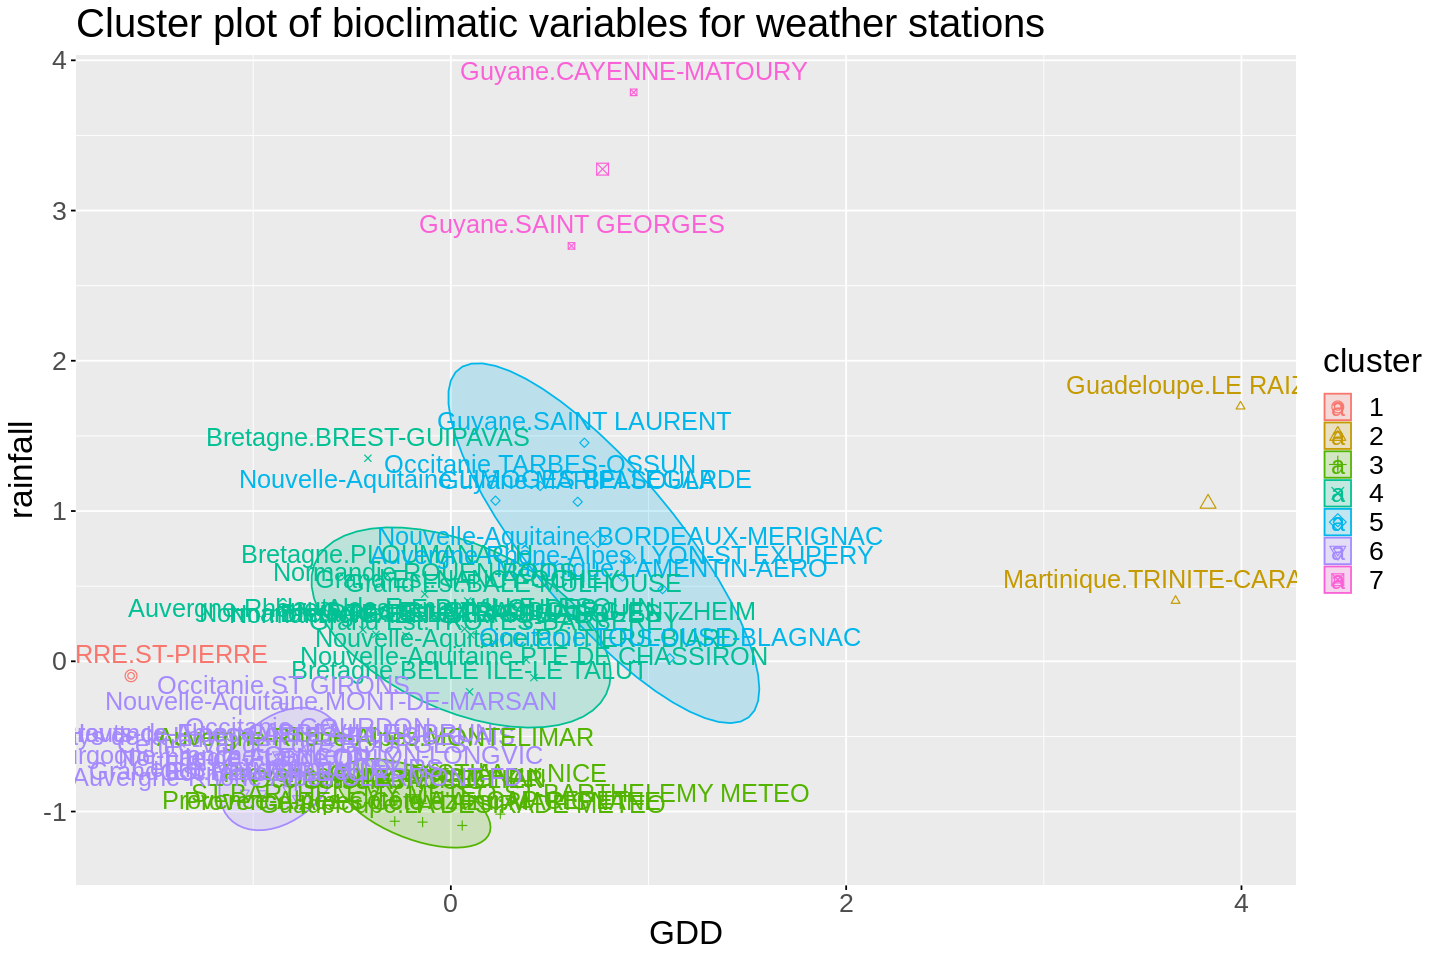

In [193]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

rownames( data = GDD_rainfall.km) <- paste( GDD_rainfall.avg$region, GDD_rainfall.avg$stationName,  sep="." )

fviz_cluster(km, data = GDD_rainfall.km,
             main="Cluster plot of bioclimatic variables for weather stations",
             labelsize=16,
             ellipse.type = "t", 
             #ggtheme = theme(legend.title = element_text(size = 20, face = "bold"),
             #                legend.text = element_text(size = 20),) 
             ggtheme = theme(text = element_text(size = 20),) 
             ) 

#### Compare clustering and Winkler index classes 

Let's see if the Winkler regions and clusters are aligned by plotting a bar plot where the bars correspond to each cluster, the height of the bar represents the number of stations in the cluster, and the color represents the Winkler index of counted stations.

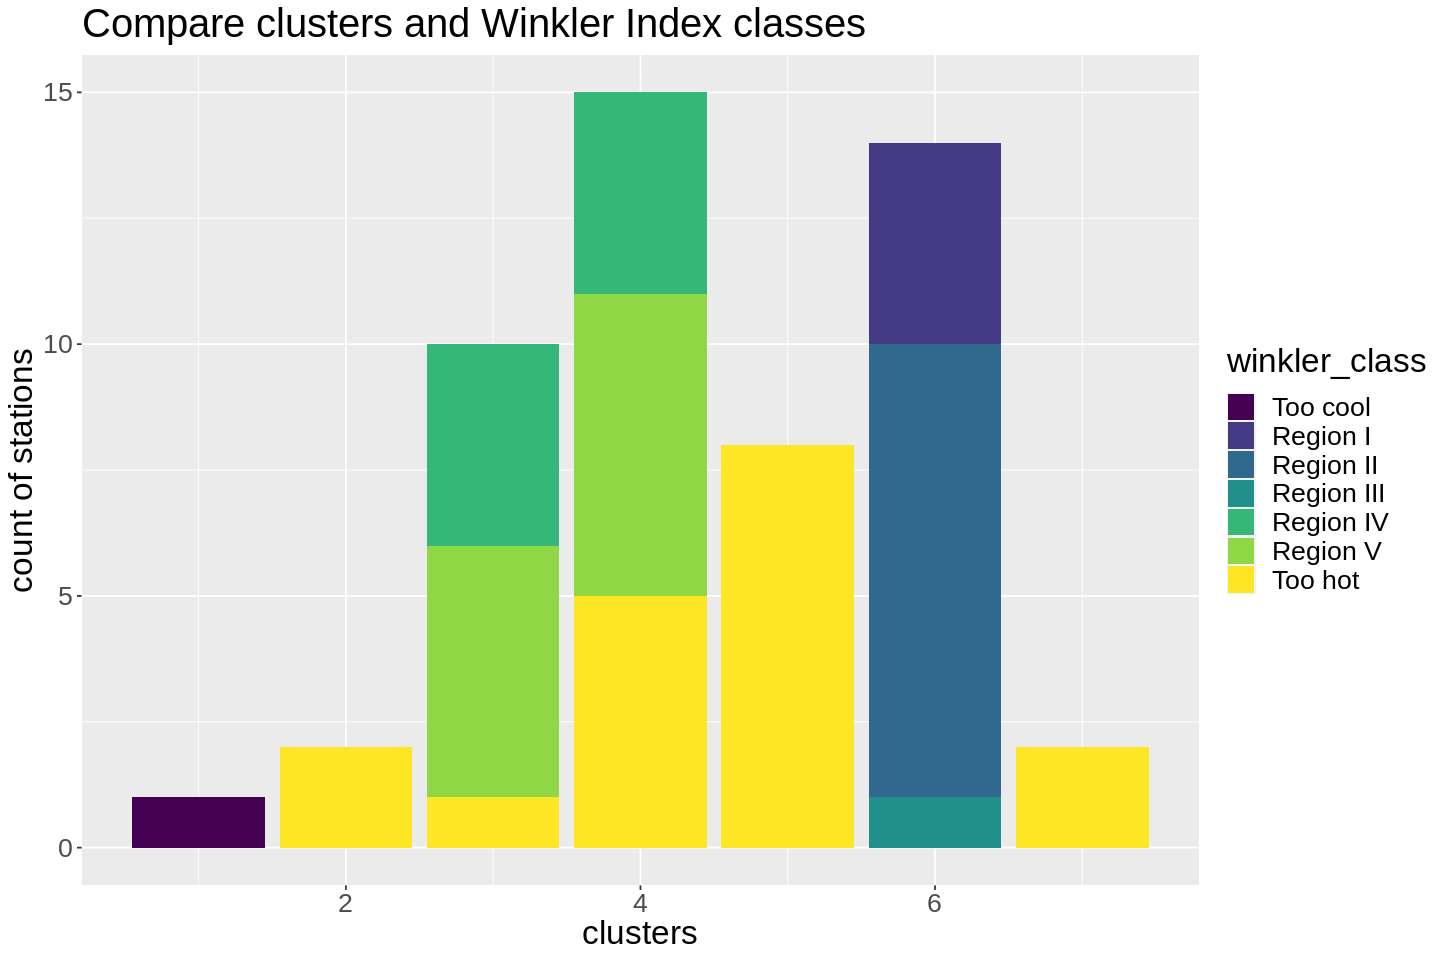

In [194]:
# Compare clustering  and GDD thresholding 
options(repr.plot.width = 12)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

GDD_rainfall.avg$cluster <- km$cluster
GDD_rainfall.avg$winkler_class <- ordered(sapply(GDD_rainfall.avg$GDD, winkler), labels= winkler_labels)

ggplot(GDD_rainfall.avg, aes(x=cluster, fill=winkler_class)) + 
      geom_bar(position = "stack")  +
      theme(text = element_text(size = 20),) +
      ggtitle("Compare clusters and Winkler Index classes") +
      xlab("clusters") +
      ylab("count of stations") 

In [195]:
# show the stations in a certain cluster 
cn <- 6
GDD_rainfall.avg[GDD_rainfall.avg$cluster == cn, c("region", "stationName", "cluster", "winkler_class")]

,region,stationName,cluster,winkler_class
,<chr>,<chr>,<int>,<ord>
15,Pays de la Loire,NANTES-BOUGUENAIS,6,Region II
24,Nouvelle-Aquitaine,MONT-DE-MARSAN,6,Region III
26,Hauts-de-France,ABBEVILLE,6,Region I
28,Île-de-France,ORLY,6,Region II
30,Grand Est,REIMS-PRUNAY,6,Region I
32,Centre-Val de Loire,TOURS,6,Region II
36,Normandie,ALENCON,6,Region I
40,Centre-Val de Loire,BOURGES,6,Region II
41,Bourgogne-Franche-Comté,DIJON-LONGVIC,6,Region II


OBSERVATIONS AND CONCLUSIONS 


---


- k-means clustering was able to identify the outlier with a climate "too cool" for wine making - Saint-Pierre island near Canada
- as well as "too hot" areas of the Caribbeans, Guyane, Guadeloupe, and Martinique
- it also put the majority of typical French wine growing regions (I,II, III) into one cluster meaning that all wine growing regions are somewhat similar to each other in their GDD and rainfall. In short, we can call this cluster a cluster of wine producing regions 
- it also shows that the hot and humid areas more diverse in their climate parameters


#### Visualize regions sets based on clusters

Let's put the regions of the stations from the cluster "wine producing areas" in one set and the regions of other stations in another. We can plot the sets on Venn diagram and see how they intersect.

In [196]:
wine_regions <- unique(GDD_rainfall.avg[GDD_rainfall.avg$cluster == 6, c("region")])
no_wine_regions <- unique(GDD_rainfall.avg[GDD_rainfall.avg$cluster != 6, c("region")])

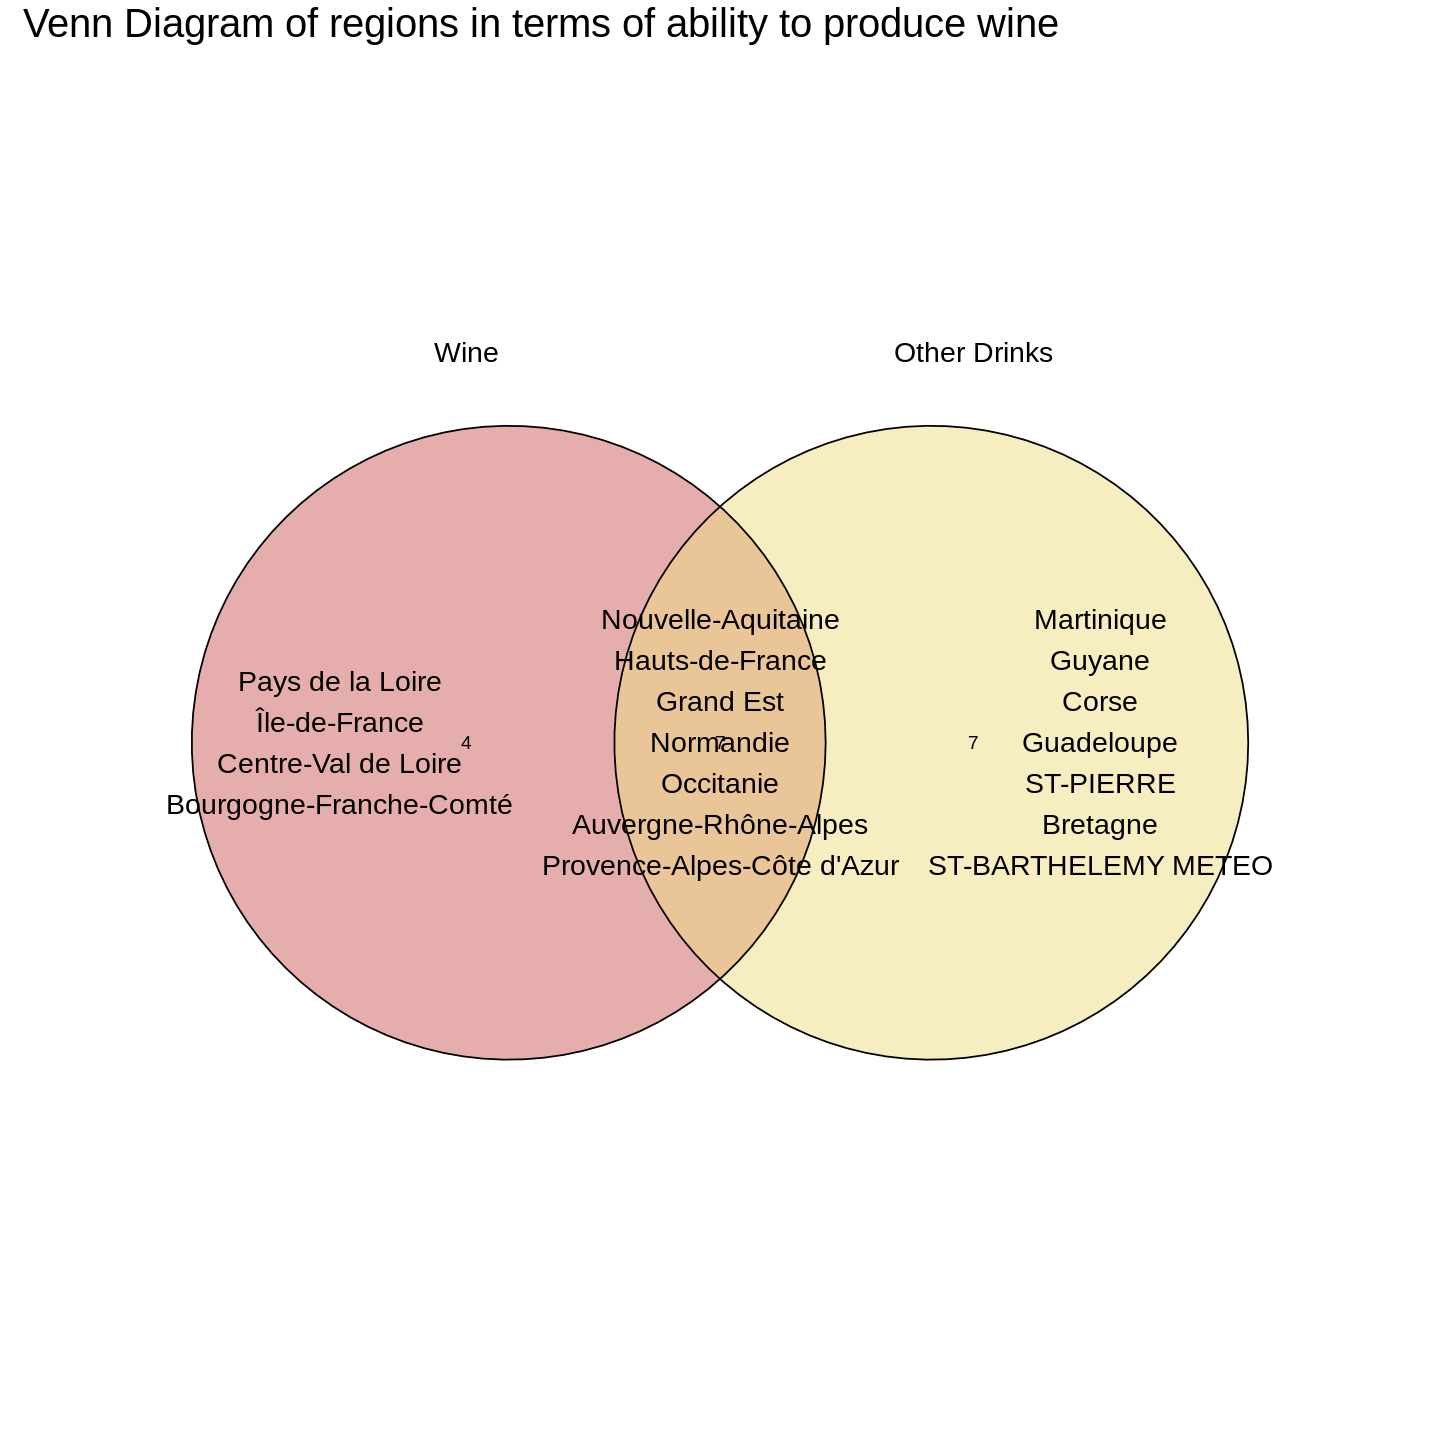

In [197]:
options(repr.plot.width = 12)
options(repr.plot.height = 12)
options(repr.plot.align = 'left')

sets <- list(
  "Wine" = wine_regions, 
  "Other Drinks" = no_wine_regions 
  )

w <- paste(setdiff(wine_regions, no_wine_regions), collapse="\n")
i <- paste(intersect(wine_regions, no_wine_regions), collapse="\n")
o <- paste(setdiff(no_wine_regions, wine_regions), collapse="\n")

#library(ggvenn)
ggvenn( sets, fill_color = c("indianred", "lightgoldenrod"),
           stroke_size = 0.5, #set_name_size = 8 ,
           show_elements = FALSE,
           show_percentage  = FALSE ) +
      theme(text = element_text(size = 20),) +
      ggtitle("Venn Diagram of regions in terms of ability to produce wine") +
      annotate("text", x= c(-1.2, 0, 1.2), y=0, label= list(w, i, o), size=6) 


OBSERVATONS AND CONCLUSIONS:

---

- the separation of the regions is very close to real life
- regions, where wine grapevines grow everywhere are identified e.g. Burgundy or Loire Valley
- regions with too hot and too cold weather e.g Martinique or Saint-Barthelemy island
- and all the others in between  
- one real mistake is Corsica as it is known for its wine

## Principal Component Analysis 

Principal Component Analysis (PCA) is a useful technique for exploratory data analysis, allowing you to better visualize the variation present in a dataset with many variables. 

The first principal component (PC1) explains the most variance in the data, the second principal component (PC2) explains the second most variance, and so on. The loading of the eigenvector represents how important each original variable is to the component.



We can combine bioclimatic and geospatial variables of wine growing regions and analyze if there is any correlation between them.

In [198]:
GDD_rainfall.wine <- GDD_rainfall[GDD_rainfall$region %in% wine_regions, ] 

In [199]:
GDD_rainfall.pca <- GDD_rainfall.wine[, c( "long", "lat", "alt", "GDD", "GST", "rainfall")]

pca <- prcomp(GDD_rainfall.pca , center=TRUE,  scale.=TRUE)
pca
summary(pca)

Standard deviations (1, .., p=6):
[1] 1.3946184 1.2725314 1.1514668 0.9423238 0.4093151 0.2330546

Rotation (n x k) = (6 x 6):
                PC1         PC2        PC3         PC4         PC5        PC6
long      0.2804039  0.12088448 -0.4344266  0.79664253 -0.21245757 -0.1955930
lat      -0.5617446  0.06946315  0.2809046  0.53039583  0.24265783  0.5103998
alt      -0.1129226  0.16676117 -0.8019060 -0.23958904  0.33251402  0.3852500
GDD       0.1240185 -0.73682416 -0.0533092  0.15670178  0.61522855 -0.1892249
GST       0.6816139 -0.13909319  0.1679956  0.02127173 -0.08159568  0.6933417
rainfall -0.3362842 -0.62489660 -0.2413475 -0.04037448 -0.63265263  0.1904970

Importance of components:
                          PC1    PC2   PC3    PC4     PC5     PC6
Standard deviation     1.3946 1.2725 1.151 0.9423 0.40932 0.23305
Proportion of Variance 0.3242 0.2699 0.221 0.1480 0.02792 0.00905
Cumulative Proportion  0.3242 0.5940 0.815 0.9630 0.99095 1.00000

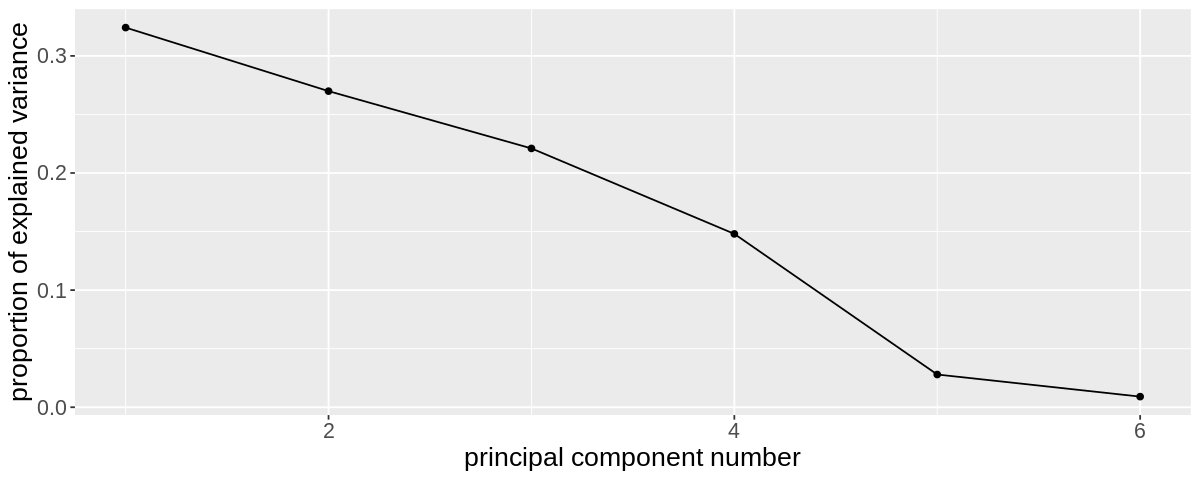

In [200]:
#probably delete
options(repr.plot.width = 10)
options(repr.plot.height = 4)

#screeplot(pca); box()
ggscreeplot(pca) +
  theme(text = element_text(size = 16))  

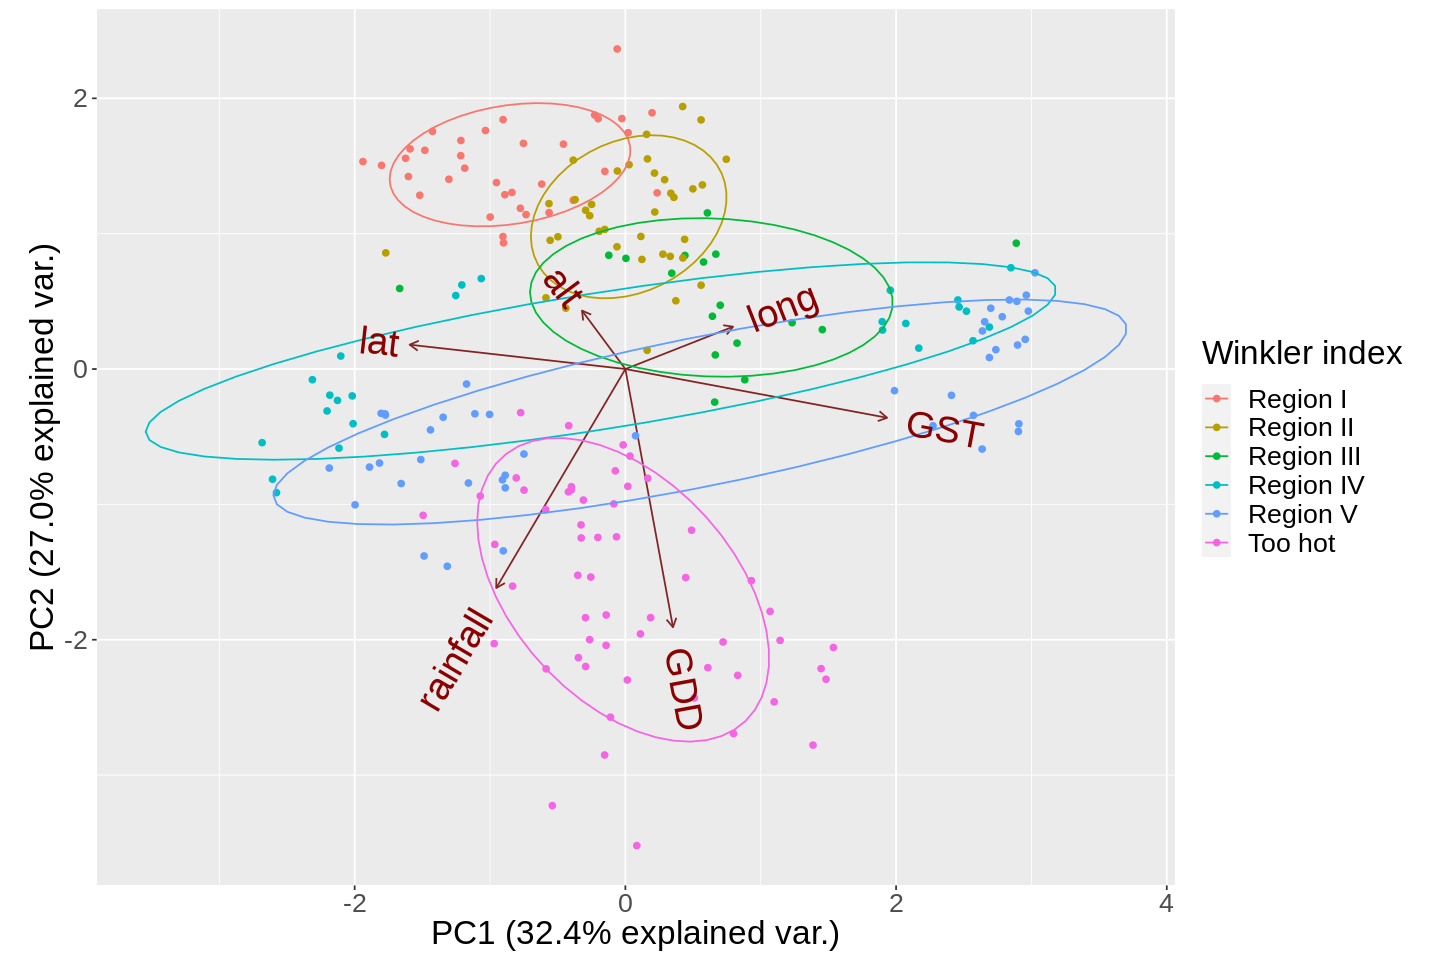

In [201]:
options(repr.plot.width = 12)
options(repr.plot.height = 8)

library(ggbiplot)

ggbiplot(pca,
         obs.scale = 1, var.scale = 1, 
         varname.size = 8,
         groups = GDD_rainfall.wine$winkler_class, 
         circle = FALSE,
         ellipse = TRUE) +
     scale_color_discrete(name = 'Winkler index') +
     theme(text = element_text(size = 20))  

OBSERVATIONS AND CONCLUSIONS:

---
- PC1 has a large positive loading on *GST* and a large negative loading on *latitude* which shows that indeed the temperature and latitude are negatively correlated 

- PC2 has negative loading on *GDD* and *rainfall*, it might indicate that GDD and rainfall are also correlated 

- PC3 has strong negative loading on *altitude* which means that it explains another portion of the variance

- the first three components explain over 80% of the total variance, we might consider keeping only these three components and reducing our data dimensionality in half if we need to 


## Supervised classification

For the classification let's consider only the wine making regions. 

Previously we already annotated the weather stations with Winkler index classes based on the GDD. 

In addition, we did some cursory research on viticulture in the areas surrounding the weather stations. We created a small Knowlege Graph of [grapevines](https://github.com/Wimmics/kgstat/blob/main/data/grapevines.ttl) in Terse RDF Triple Language ([Turtle](https://www.w3.org/TR/turtle/)) and modeled it with very well-known [Wine Ontology](http://oaei.ontologymatching.org/2007/benchmarks/102/onto.html).

Based on this research we can label the stations with:
- binary "yes" and "no" classes 
- prevalent white wine grape varieties (fr: cepage)
- prevalent red wine grape varieties

TODO: replace url

### Labeling the data for supervised classification

In [202]:
options(readr.show_col_types = FALSE)

# define name spaces used by grapevines mini-dataset
namespaces <- c(rdf= "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
                vin= "http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#",
                wekg= "http://ns.inria.fr/meteo/weatherstation/")

# read the file into rdf object
grapevines.rdf <- rdf_parse("https://raw.githubusercontent.com/AnnaBobasheva/KG-R/main/data/grapevines.ttl",
                            format="turtle")

In [203]:
# query the rdf object as we would query an endpoint
query_grapevines <- '
PREFIX vin: <http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#> 
  
SELECT ?station ?cepage ?type
WHERE { ?cepage vin:locatedIn ?station;
                vin:madeIntoWine ?type. }
'

vins <- rdf_query(grapevines.rdf, sparql_rouges, data.frame=TRUE)

# rdflib does not provide functionaluty to subtitute namespaces with prefixes
vins$cepage <- sub(namespaces["vin"], "", vins$cepage)
vins$type   <- sub(namespaces["vin"], "", vins$type)

#table(vins$cepage)
#table(vins$type)

In [204]:
# merge the bioclimatic and geospatial data and viticulture data
GDD_rainfall.wine.cls <- GDD_rainfall.wine

GDD_rainfall.wine.cls <- merge(GDD_rainfall.wine.cls , vins[vins$type == "WhiteWine",], by ="station", all.x=TRUE)
GDD_rainfall.wine.cls$cepage_blanc <- na.fill(GDD_rainfall.wine.cls$cepage, "raisins")
GDD_rainfall.wine.cls$cepage_blanc <- factor(GDD_rainfall.wine.cls$cepage_blanc)
GDD_rainfall.wine.cls <- subset(GDD_rainfall.wine.cls, select = -c(cepage, type))

GDD_rainfall.wine.cls <- merge(GDD_rainfall.wine.cls , vins[vins$type == "RedWine",], by ="station", all.x=TRUE)
GDD_rainfall.wine.cls$cepage_rouge <- na.fill(GDD_rainfall.wine.cls$cepage, "raisins")
GDD_rainfall.wine.cls$cepage_rouge <- factor(GDD_rainfall.wine.cls$cepage_rouge)
GDD_rainfall.wine.cls <- subset(GDD_rainfall.wine.cls, select = -c(cepage, type))

# create binary labels 
GDD_rainfall.wine.cls$class_bin <- ifelse(GDD_rainfall.wine.cls$cepage_rouge == "raisins" &
                                          GDD_rainfall.wine.cls$cepage_blanc == "raisins" , 0, 1)

In [205]:
# refactor Winkler index because some of the classes might be gone
GDD_rainfall.wine.cls$winkler_class <- factor(GDD_rainfall.wine.cls$winkler_class)

In [206]:
# split dataset reserving the last year of the dataset for testing
train <- GDD_rainfall.wine.cls[GDD_rainfall.wine.cls$year <  2021 , ]
test  <- GDD_rainfall.wine.cls[GDD_rainfall.wine.cls$year == 2021,  ]

### Logistic Regression 

Let's see if we can predict from the geospatial and bioclimatic variables if an area around a weather station can grow grapevines or not. 

In [207]:
# Fit a logistic regression model using class_bin as the response variable and wt as the predictor variable
train.bin <- train[, c( "lat", "alt", "GDD", "GST", "rainfall", "class_bin")]
test.bin <-  test [, c( "lat", "alt", "GDD", "GST", "rainfall", "class_bin")]

lr <- glm(class_bin ~ ., data = train.bin, family = binomial())

# Make predictions on the test data
predictions <- predict(lr, newdata=test.bin, type = "response")

# Create a threshold of 0.5
predictions <- ifelse(predictions > 0.5, 1, 0)

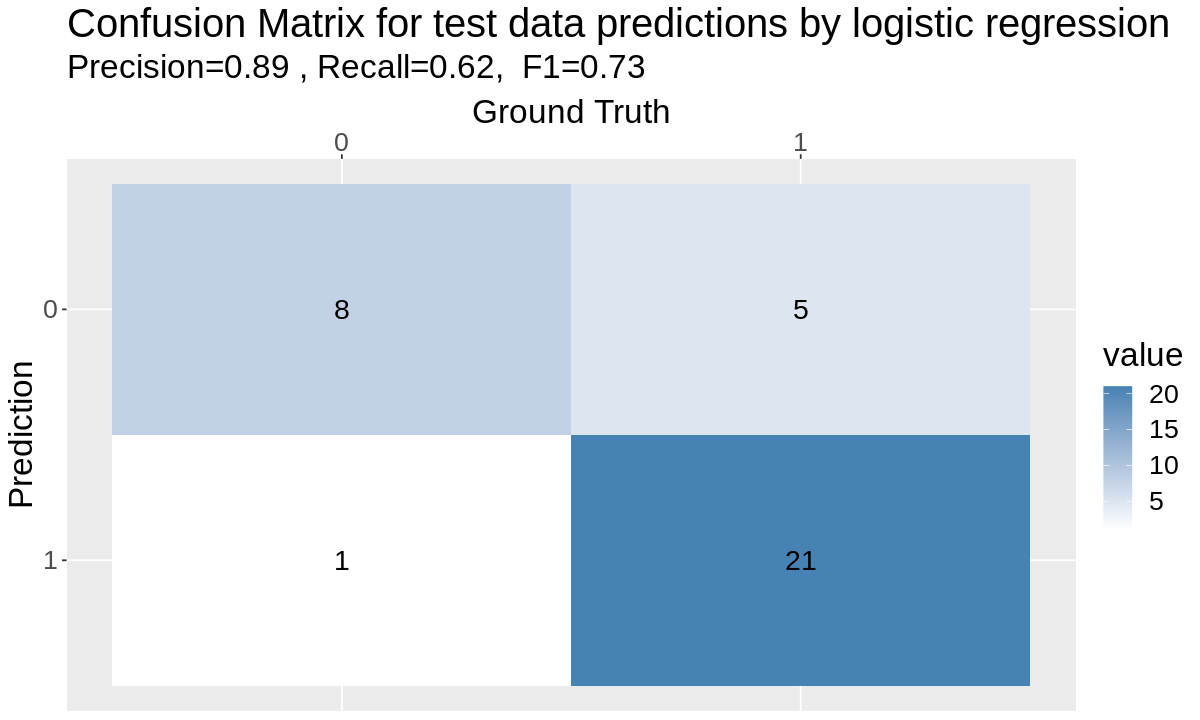

In [208]:
# Visualize the quality metrics of test predictinons
options(repr.plot.width = 10)
options(repr.plot.height = 6)

# Create a confusion matrix
confusion_matrix <- table(predictions, test.bin$class_bin)
normalized_matrix <- confusion_matrix / rowSums(confusion_matrix)

# Calculate the F1 score
precision <- confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[2,1])
recall <- confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,2])
f1_score <- 2 * (precision * recall) / (precision + recall)

ggplot(melt(confusion_matrix), aes(x=factor(Var2), y=factor(predictions), fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +

  theme(text = element_text(size = 20),) +

  scale_y_discrete(limits=rev) +
  scale_x_discrete(position = "top") +
  scale_fill_gradient(low="white", high="steelblue") +

  labs(title="Confusion Matrix for test data predictions by logistic regression",
       subtitle = sprintf("Precision=%.2f , Recall=%.2f,  F1=%.2f", 
                          precision,
                          recall, 
                          f1_score),
        x="Ground Truth",
        y="Prediction" )  

OBSERVATIONS AND CONCLUSIONS

---


- indeed the bioclimatic and geospatial parameters define the grapevine growing potential of the area pretty well

### Multinomial logistic regression
probably delete

Let's consider the more difficult task of predicting the Winkler Index of an area around weather stations with *multinomial* regression.

In [209]:
train.mult <- train[, c( "lat", "alt", "GST", "rainfall", "winkler_class")]
test.mult  <- test [,  c( "lat", "alt", "GST", "rainfall", "winkler_class")]

# Fit a multi-class logistic regression model
tune_grid <- expand.grid(.decay=c(0, 0.1, 0.5, 1))
multinomial_LR <- train(winkler_class ~ ., data = train.mult, 
                        method = "multinom" ,
                        tuneGrid=tune_grid, 
                        trace = FALSE)


  Region I  Region II Region III  Region IV   Region V    Too hot 
        12          3          1          6          8          5 

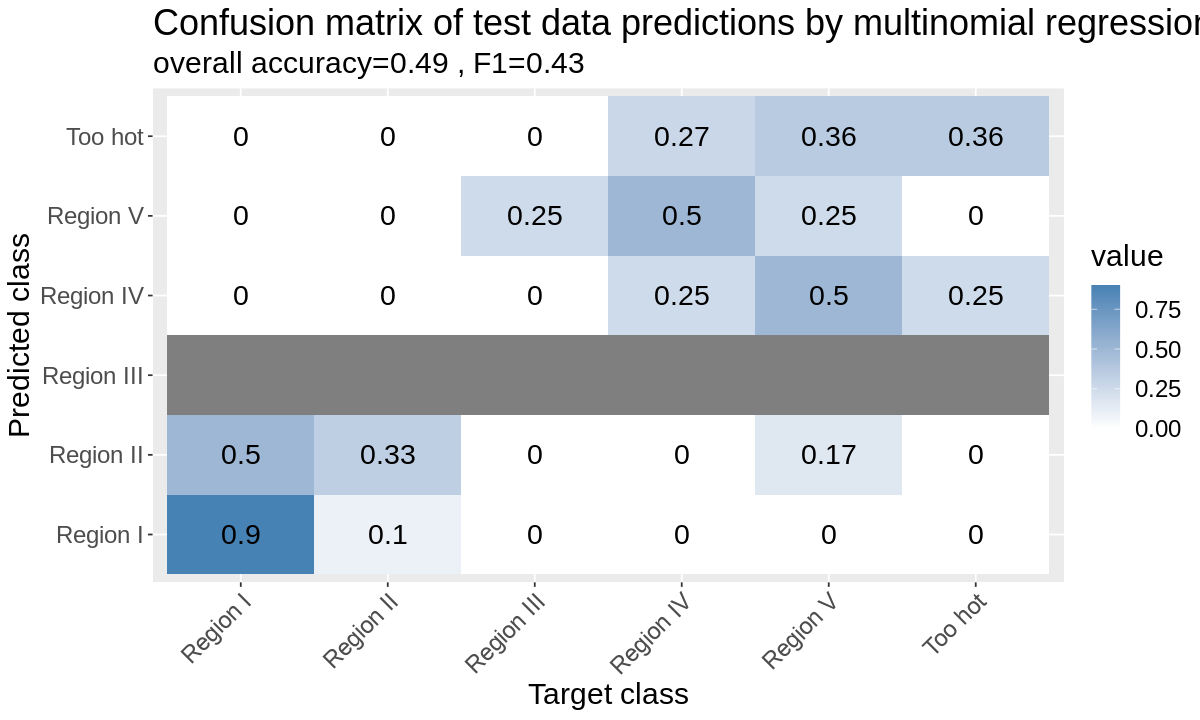

In [210]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)

# Make predictions on the test set
predictions <- predict(multinomial_LR , test.mult)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(predictions, test.mult$winkler_class, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

table(test.mult$winkler_class)

ggplot(melt(normalized_matrix), aes(x=Reference , y=Prediction, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +

  theme(text = element_text(size = 18),
        axis.text.x=element_text(angle=45, hjust=1)) +

  scale_fill_gradient(low="white", high="steelblue") +

  labs(title="Confusion matrix of test data predictions by multinomial regression ",
       subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)),
       x="Target class",
       y="Predicted class" )

OBSERVATONS AND CONCLUSIONS


---

- the multinomial logistic regression did not give us spectacular results
- Region III was not predicted at all 


We can try other classification models though.

### Decision tree

To train a decision tree model we can either use the original implementation of the `rpart`. This library implements recursive partitioning and is very easy to use. 

Or using the `caret` package we can just change the *method* parameter to train another type of model, e.g. Decision Tree or Random Forest. With `caret` we can also easily specify the hyper-parameter for fine-tuning. 



#### Winkler index classifier

In [211]:
train.winkler <- train[, c( "lat", "alt", "GST", "rainfall", "winkler_class")]
test.winkler <-  test [, c( "lat", "alt", "GST", "rainfall", "winkler_class")]

# using just rpart from standard stats package
# NOTE: the confusion matrix cannot be generated.
#library(rpart)
#rpart.winkler <- rpart(winkler_class~., data=train.winkler)

# the same but with caret optimizing complexity parameter cp
tune_grid <- expand.grid(.cp=c(0.01, 0.1, 1))
rpart.winkler <- train(winkler_class ~ ., data = train.winkler, method = "rpart", tuneGrid=tune_grid )

Visualize performance metrics and the decision tree.

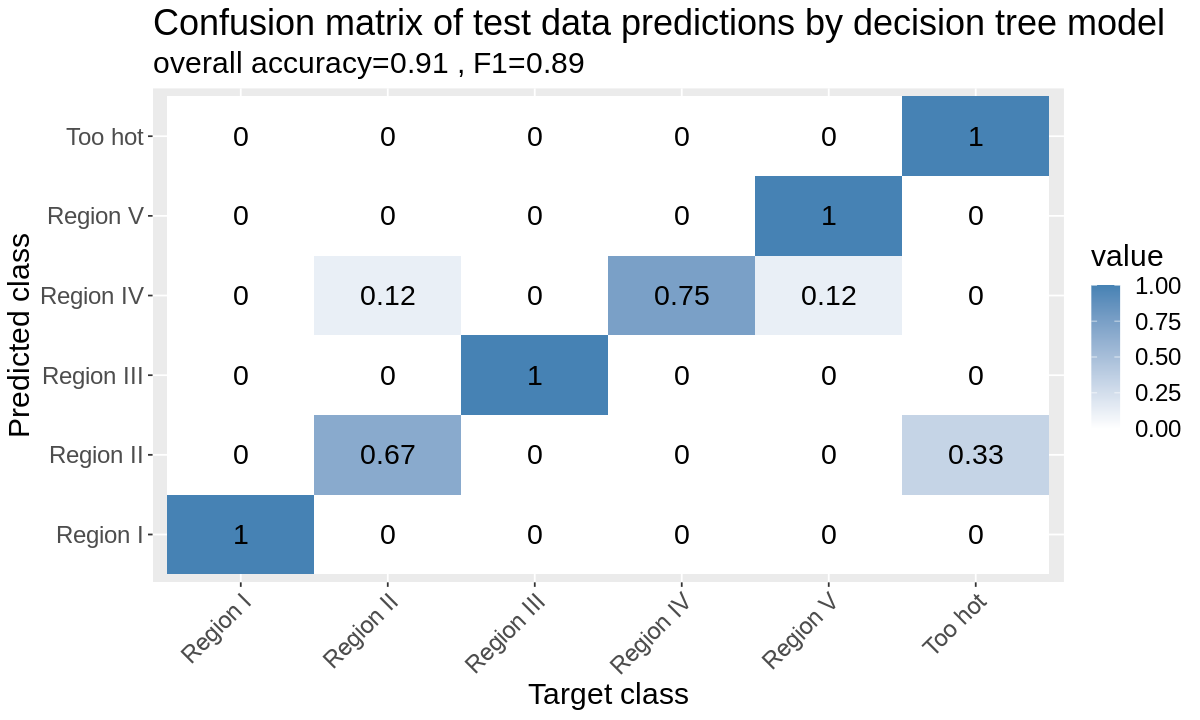

In [212]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)

# Make predictions on the test set
predictions <- predict(rpart.winkler , test.winkler)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(predictions, test.winkler$winkler_class, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

ggplot(melt(normalized_matrix), aes(x=Reference , y=Prediction, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +

  theme(text = element_text(size = 18),
        axis.text.x=element_text(angle=45, hjust=1)) +

  scale_fill_gradient(low="white", high="steelblue") +

  labs(title="Confusion matrix of test data predictions by decision tree model ",
       subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)),
       x="Target class",
       y="Predicted class" )

In _rpart.plot_ decision tree visualization a positive brunch is to the left and a negative brunch is to the right of a decision node as shown on the top of the tree.

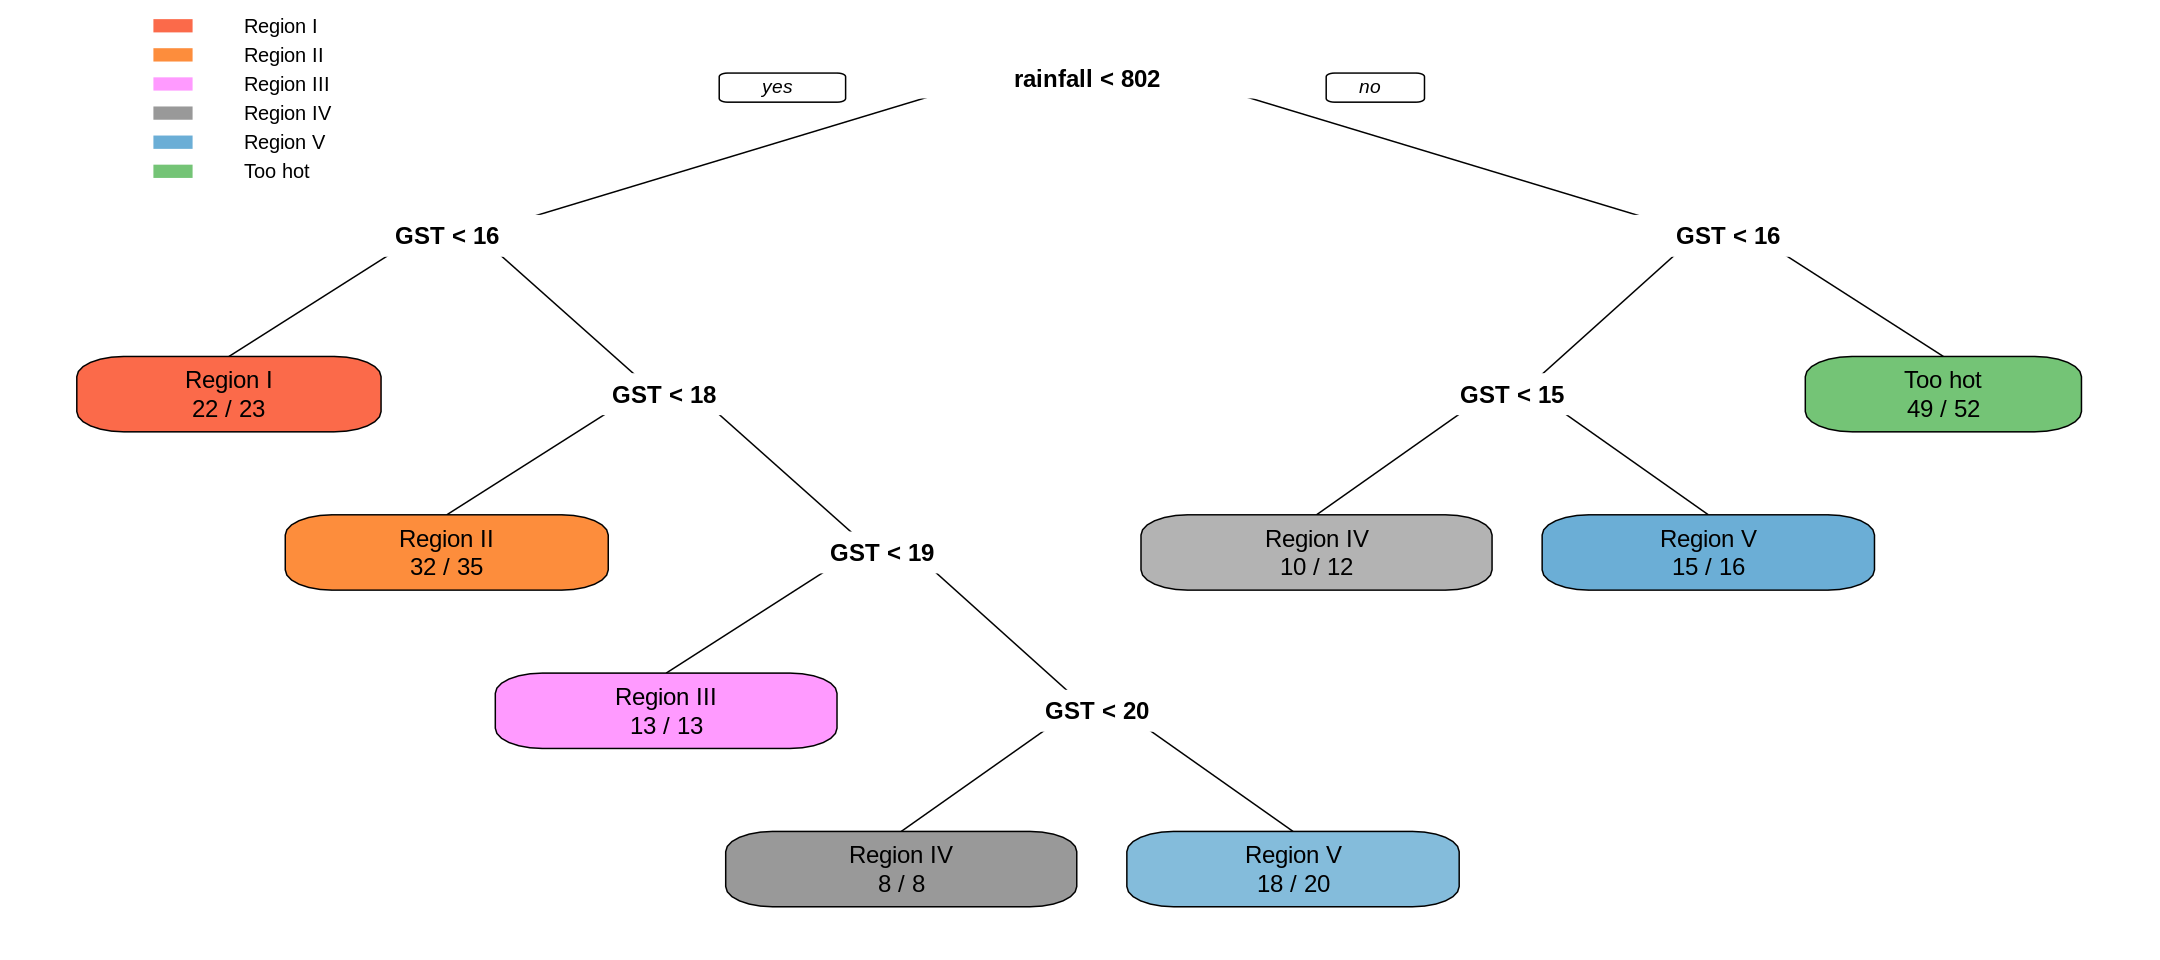

In [213]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)

rpart.plot(rpart.winkler$finalModel, 
          type=0, 
          extra=2,
          fallen.leaves=FALSE,
          cex=1.2,
          box.palette= "auto")          

OBSERVATIONS AND CONCLUSIONS:

---

- the fine-tuned decision tree algorithm uses only bioclimatic variables to build a pretty accurate predictive model of the area's Winkler Index, it ignores the geographical location 
- some odd confusions: _too hot_ and _Region II_ 

We can try other classification models, e.g. Random Forest,  by simply changing the *method* parameter of the  *train* function  of `caret` package.

#### White wine classifier

In [230]:
train.blanc <- train[, c( "lat", "alt", "GDD",  "rainfall", "cepage_blanc")]
test.blanc <-  test [, c( "lat", "alt", "GDD",  "rainfall", "cepage_blanc")]

# using just rpart from standard stats package
#library(rpart)
#rpart.blanc <- rpart(cepage_blanc~., data=train.blanc)

# the same but with caret optimizing complexity parameter cp
tune_grid <- expand.grid(.cp=c(0.01, 0.1, 1))
rpart.blanc <- train(cepage_blanc ~ ., data = train.blanc, method = "rpart", tuneGrid=tune_grid )

# the same but with caret optimizing max depth 
#tune_grid <- expand.grid(.maxdepth=2:10)
#rpart.blanc <- train(cepage_blanc ~ ., data = train.blanc, method = "rpart2", tuneGrid=tune_grid )

Visualize performance metrics and the decision tree.

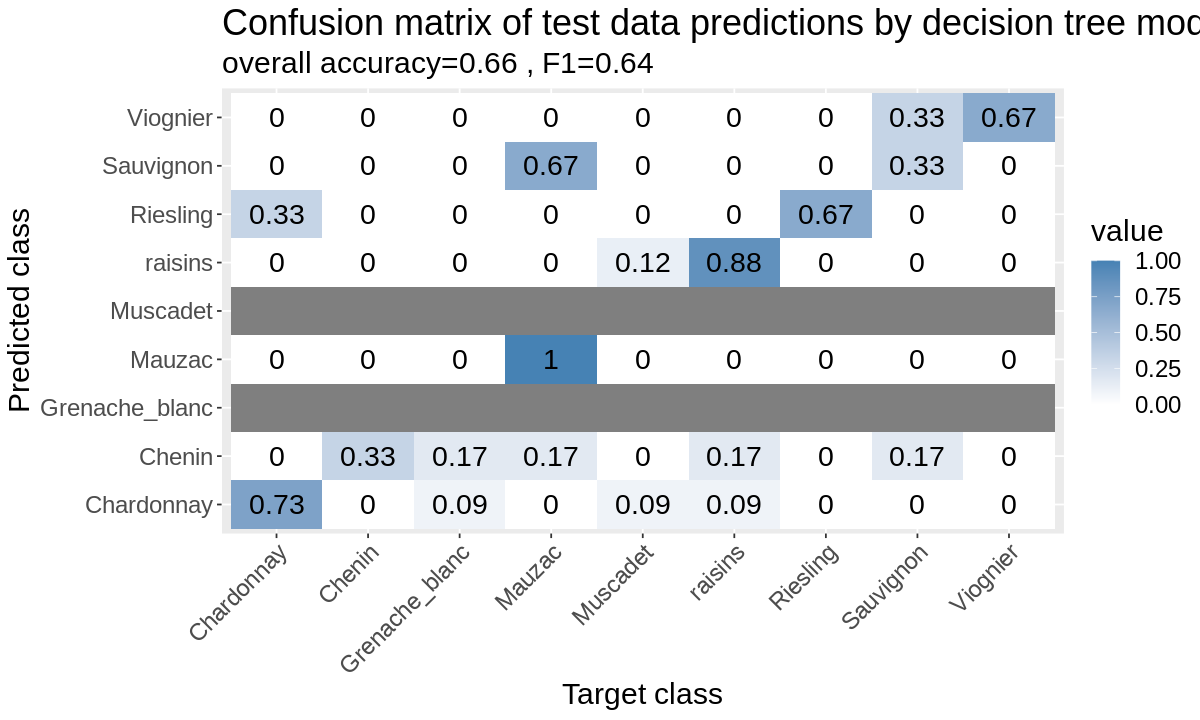

In [231]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)

# Make predictions on the test set
pred_blanc <- predict(rpart.blanc , test.blanc)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(pred_blanc, test.blanc$cepage_blanc, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

ggplot(melt(normalized_matrix), aes(x=Reference, y=Prediction, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +

  theme(text = element_text(size = 18),
        axis.text.x=element_text(angle=45, hjust=1)) +

  scale_fill_gradient(low="white", high="steelblue") +

  labs(title="Confusion matrix of test data predictions by decision tree model ",
       subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)),
       x="Target class",
       y="Predicted class" )

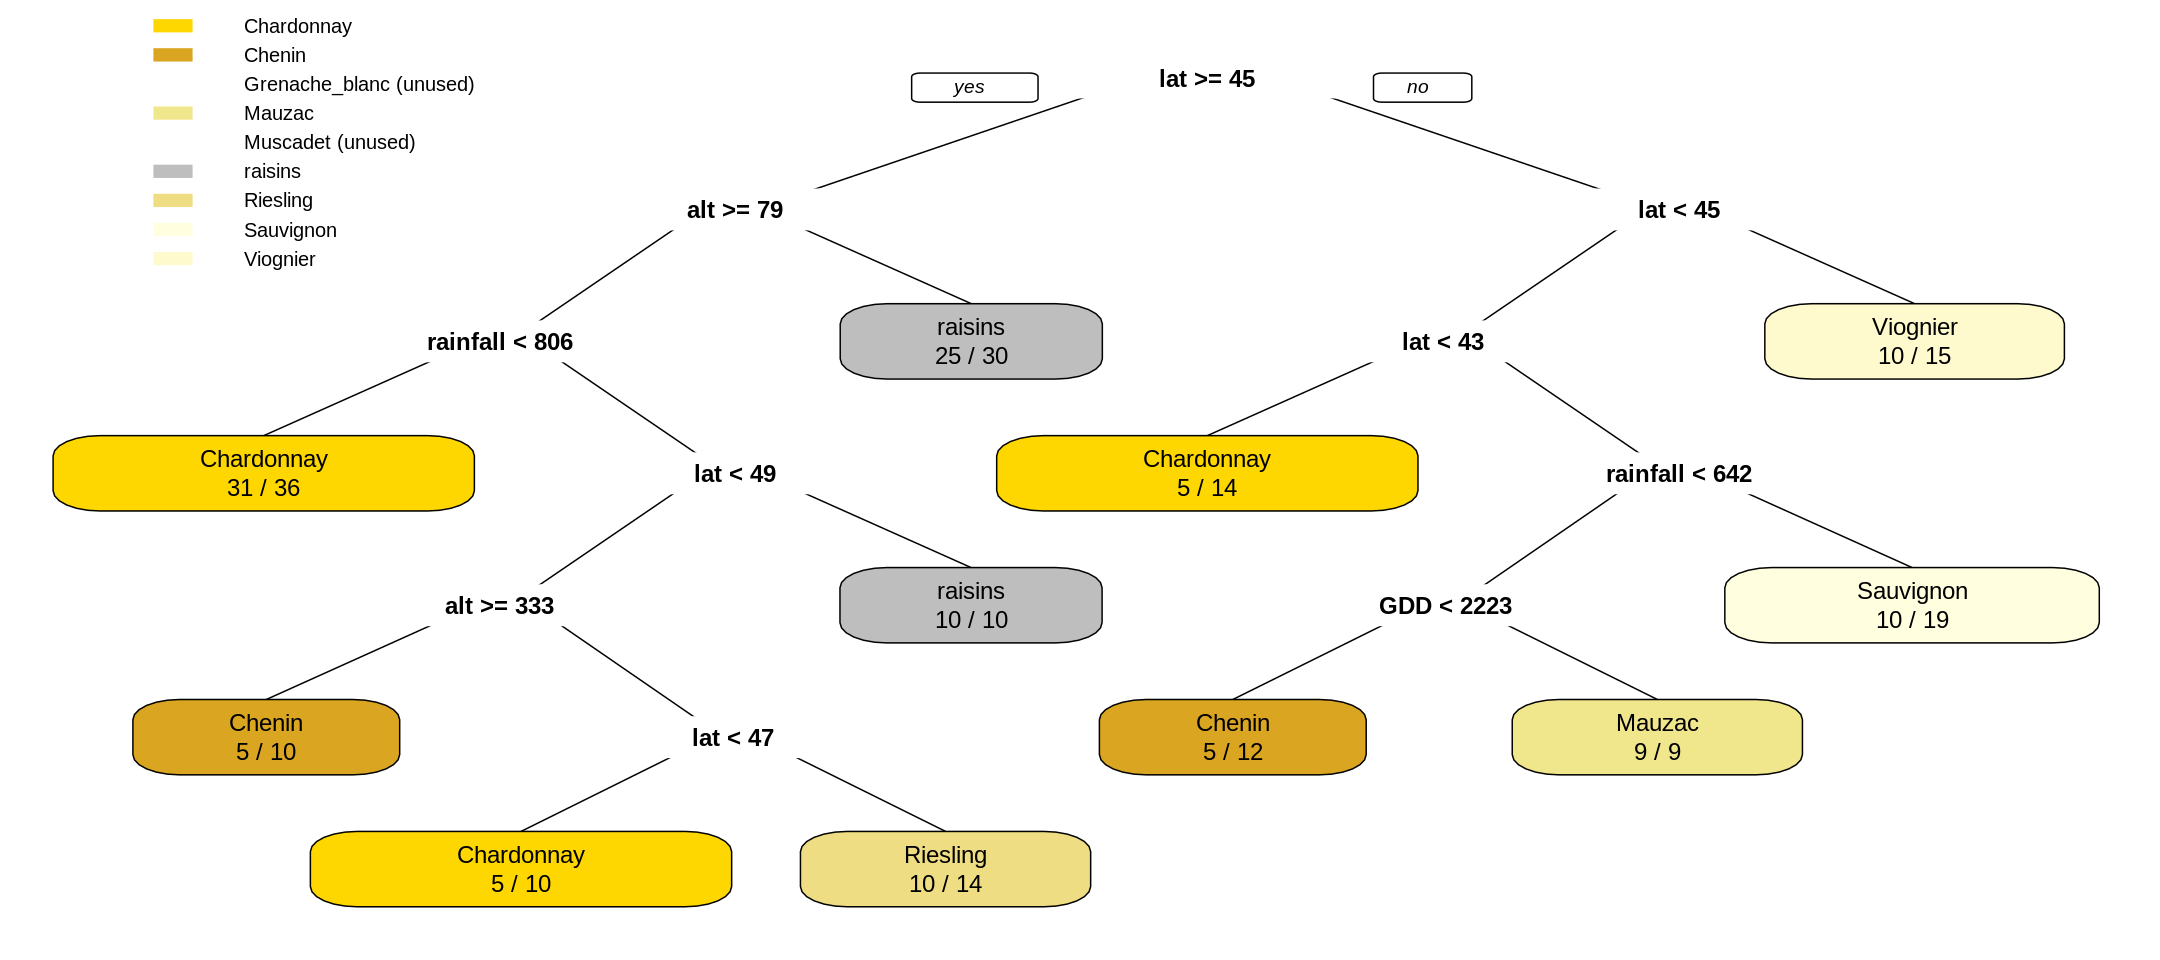

In [232]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

# The colors for the leaves came from here: https://r-charts.com/colors/
blanc_colors <- list("gold", "goldenrod",  "khaki", "gray", "lightgoldenrod",
                     "lightyellow",  "lemonchiffon",   "wheat", "yellow",
                      "palegreen", "orange", "navajowhite")

rpart.plot(rpart.blanc$finalModel, 
          type=0, 
          extra=2,
          fallen.leaves=FALSE,
          cex=1.2,
          box.palette= blanc_colors)          

OBSERVATONS AND CONCLUSIONS

---

- in the case of the white grape varieties, the decision tree model uses mostly geographic coordinates to build a predictive model of growing grape varieties in the weather station area

- according to the model, Chardonnay is the most versatile variety as it grows in the north and the south

- all the areas south of 45°N produce white wines

- Riesling grows only in the north and Sauvignon and Viogner only in the south. 

- 2 varieties Grenache Blanc and Muscadet could not be predicted 

We can try other classification models, e.g. Random Forest, by simply changing the *method* parameter of the *train* function of `caret` package.


#### Red wine classifier

In [217]:
train.rouge <- train[, c( "lat", "alt", "GDD",  "rainfall", "cepage_rouge")]
test.rouge <-  test [, c( "lat", "alt", "GDD",  "rainfall", "cepage_rouge")]

# using just rpart from standard stats package
# NOTE: generation of confusion matrix requires some additional code 
#library(rpart)
#rpart.rouge <- rpart(cepage_rouge~., data=train.blrougeanc)

# the same but with caret optimizing complexity parameter cp
#tune_grid <- expand.grid(.cp=c(0.01, 0.1, 1))
#rpart.rouge <- train(cepage_rouge ~ ., data = train.rouge, method = "rpart", tuneGrid=tune_grid )

# the same but with caret optimizing max depth 
tune_grid <- expand.grid(.maxdepth=2:10)
rpart.rouge <- train(cepage_rouge ~ ., data = train.rouge, method = "rpart2", tuneGrid=tune_grid )

Visualize performance metrics and the decision tree.

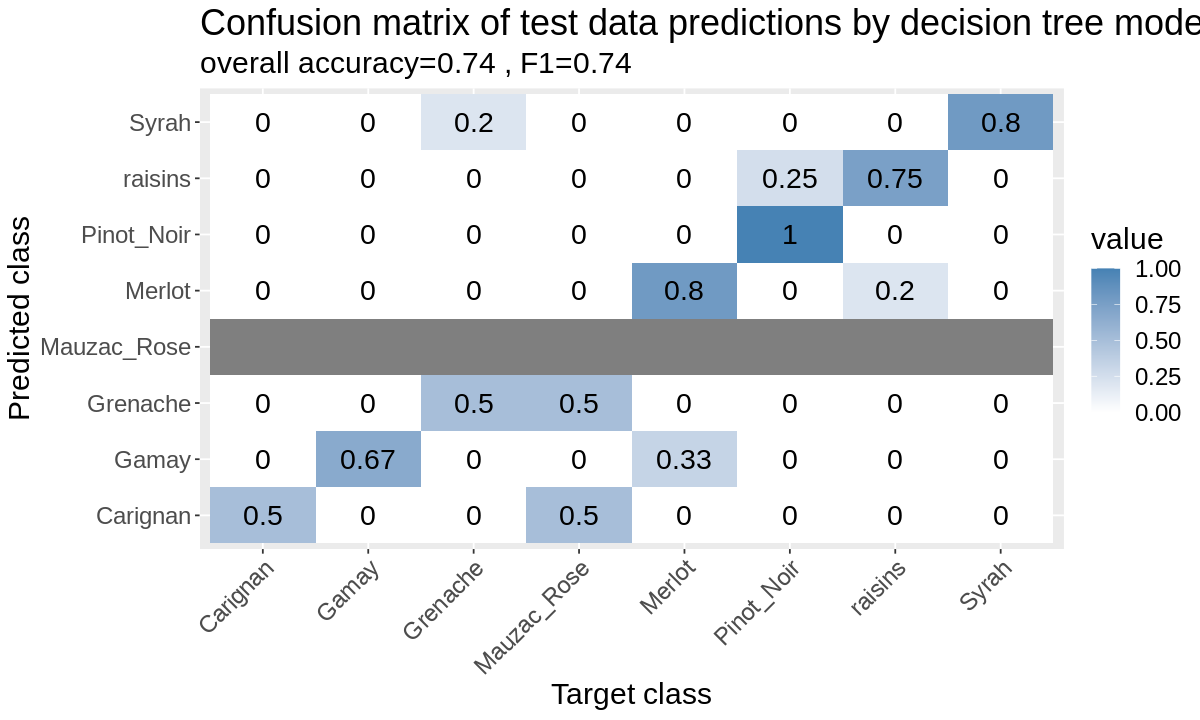

In [224]:
options(repr.plot.width = 10)
options(repr.plot.height = 6)

# Make predictions on the test set
pred_rouge <- predict(rpart.rouge , test.rouge)

# Evaluate the model's performance
confusion_matrix  <- confusionMatrix(pred_rouge, test.rouge$cepage_rouge, mode = "prec_recall")
normalized_matrix <- confusion_matrix$table / rowSums(confusion_matrix$table)

ggplot(melt(normalized_matrix), aes(x=Reference, y=Prediction, fill=value)) +
  geom_tile() +
  geom_text(aes(label=round(value, 2) ), size=6) +

  theme(text = element_text(size = 18),
        axis.text.x=element_text(angle=45, hjust=1)) +

  scale_fill_gradient(low="white", high="steelblue") +

  labs(title="Confusion matrix of test data predictions by decision tree model ",
       subtitle = sprintf("overall accuracy=%.2f , F1=%.2f", 
                          confusion_matrix$overall["Accuracy"], 
                          mean(confusion_matrix$byClass[, "F1"], na.rm=TRUE)),
       x="Target class",
       y="Predicted class" )

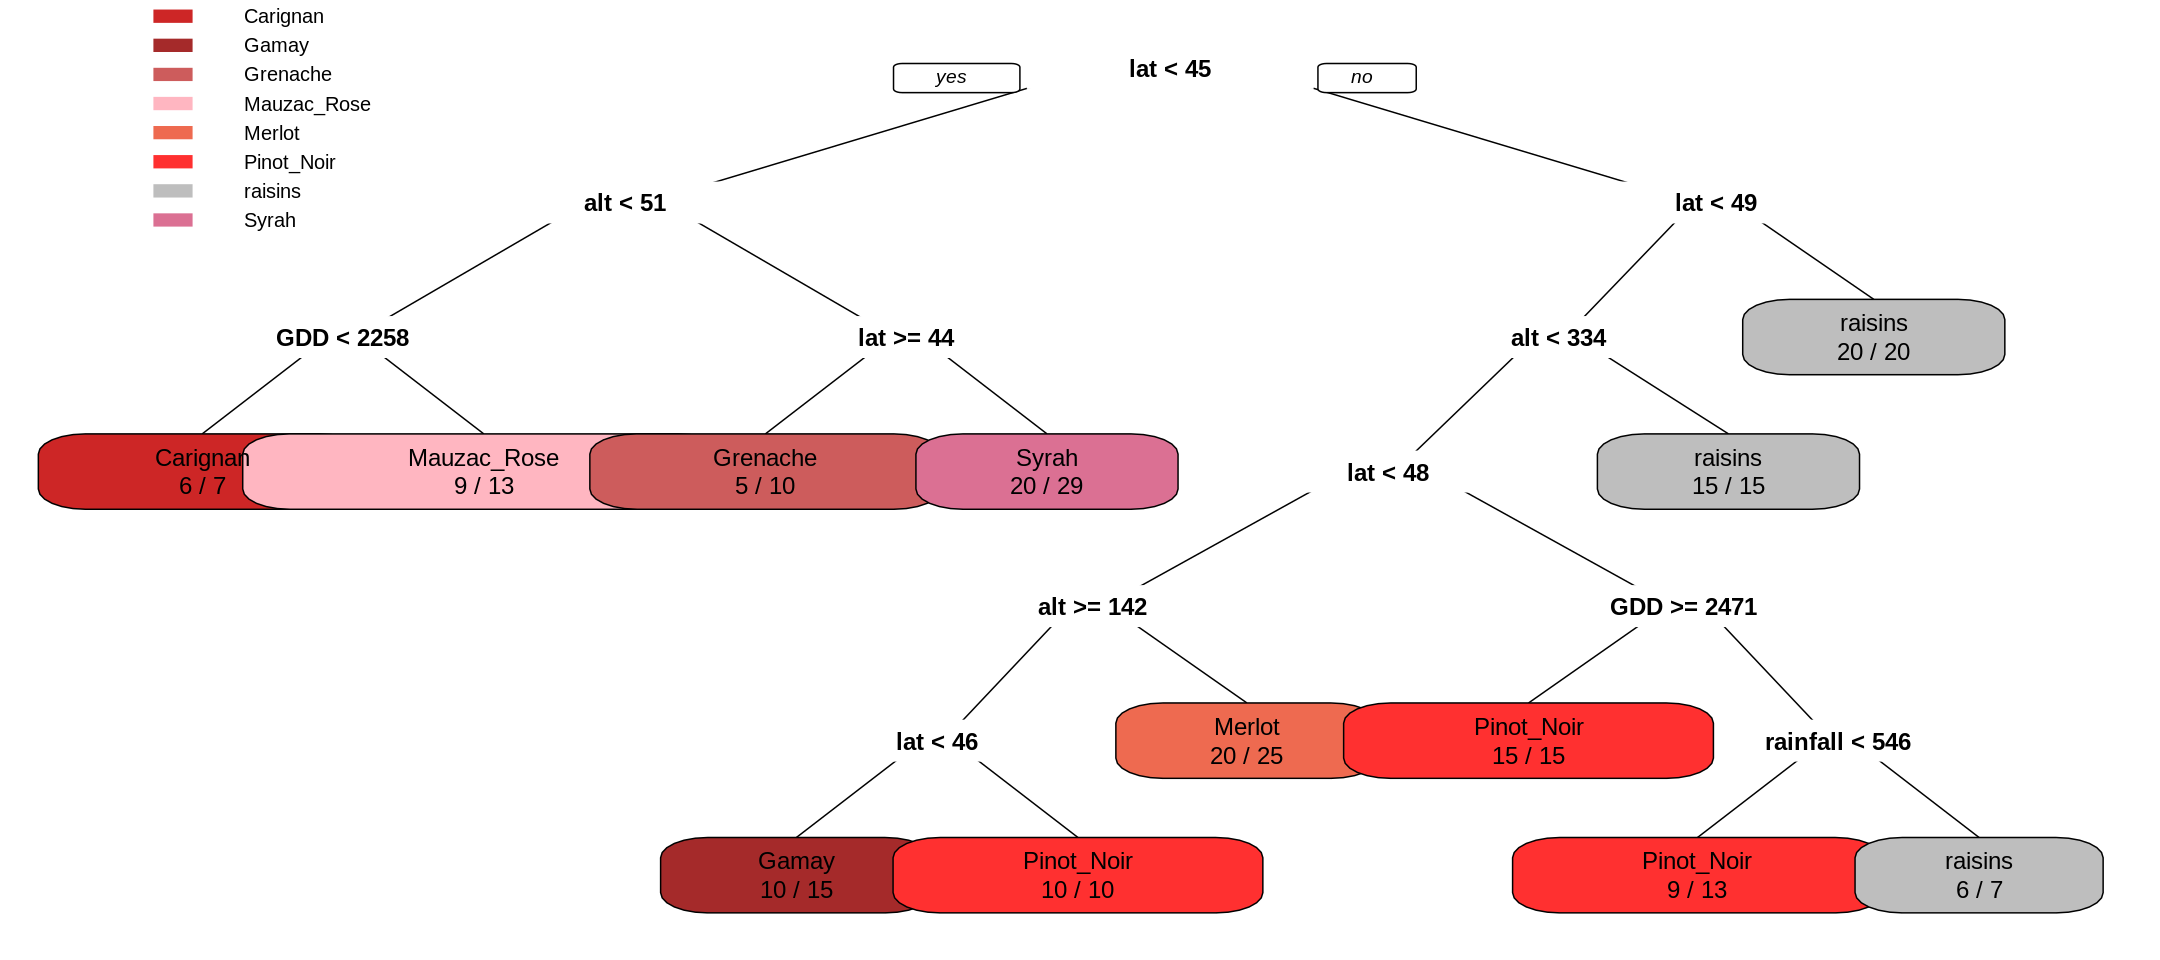

In [223]:
options(repr.plot.width = 18)
options(repr.plot.height = 8)
options(repr.plot.align = 'left')

# The colors for the leaves came from here: https://r-charts.com/colors/
rouge_colors <- list( "firebrick3", "brown", "indianred",  "lightpink", "coral2",  "firebrick1", "gray",
                      "palevioletred",  "pink3", "rosybrown", "tomato",  "lightsalmon" )

rpart.plot(rpart.rouge$finalModel, 
          type=0, 
          extra=2,
          fallen.leaves=FALSE,
          cex=1.2,
          box.palette= rouge_colors)          

OBSERVATIONS AND CONCLUSIONS


---

- in the case of the red wine grape varieties, the decision tree model uses both geospatial and bioclimatic variables to predict growing grape varieties in the weather station areas

- all the areas south of 45°N produce red wines as well

- Pinot Noir grows only towards the north and requires a mild dry climate, Merlot and Gamay are also in the north of 45N and can be confused with one another

- south of the 45°N Syrah is pretty accurately predicted, however the predictions of Carignan, Grenache, and Mauzac Rose is not at all accurate and there is a lot of confusion between them

We can try other classification models, e.g. eXtreme Gradient Boosting or Random Forest, by changing the *method* parameter of the  *train* function of `caret` package to _"xgbTree"_ or _"rf"_ and giving the proper hyperparameters to tune. For details refer to this tutorial: https://csantill.github.io/RTuningModelParameters/ 



## Future work

We can extend the dataset with more weather variables from the WeKG-MF and calculate other bioclimatic metrics such as [Huglin Index](https://en.wikipedia.org/wiki/Huglin_index) and use other classification models from the wide range offered by R. 

